# Code that takes in COLMAP results of a scene ([2D,3D] points), obtains a coarse DEM in the region of interest, scales to [m] of this coarse DEM, then refines to finer point like Lidar data



In [87]:
import os
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
#import numba as nb
import cv2
from scipy.interpolate import interp2d, interp1d
from scipy.interpolate import griddata
from scipy.interpolate import RegularGridInterpolator,LinearNDInterpolator
from mpl_toolkits import mplot3d
import matplotlib
import elevation
from tqdm import tqdm
import numdifftools
%matplotlib widget
from memory_profiler import profile
from astropy.nddata import block_reduce

### Read in Point Cloud

In [2]:
cwd = os.getcwd()
file_pt =os.path.join(cwd,'CORE3D/Building_1/images/fused.ply')
pcd = o3d.io.read_point_cloud(file_pt)
pcd_points=np.array(pcd.points)
pcd_colors=np.array(pcd.colors)
pcd_normals=np.array(pcd.normals)

#o3d.visualization.draw_geometries([pcd])

### Read in Sparse 3D points and 2D points

In [3]:
point3dfile = os.path.join(cwd,'CORE3D/Building_1/points3D-sparse.txt')
point2dfile = os.path.join(cwd,'CORE3D/Building_1/images-sparse.txt')
with open(point3dfile,'r') as f:
    data3d = f.readlines()
with open(point2dfile,'r') as f:
    data2d = f.readlines()

### Allocate all the 2D variables

In [4]:
n_images = int(len(data2d)/2) 
image_id = [] ; camera_id = [] ; camera_name = []
qw=[] ; qx=[] ; qy = []; qz = []; tx = []; ty = []; tz = []
for i in range(n_images):
    image_id.append(data2d[int(i*2)].split(' ')[0])
    qw.append(data2d[int(i*2)].split(' ')[1])
    qx.append(data2d[int(i*2)].split(' ')[2])
    qy.append(data2d[int(i*2)].split(' ')[3])
    qz.append(data2d[int(i*2)].split(' ')[4])
    tx.append(data2d[int(i*2)].split(' ')[5])
    ty.append(data2d[int(i*2)].split(' ')[6])
    tz.append(data2d[int(i*2)].split(' ')[7])
    camera_id.append(data2d[int(i*2)].split(' ')[8])
    camera_name.append(data2d[int(i*2)].split(' ')[9])
print(camera_id[0])
print(camera_name[0])

1
01MAY15WV031200015MAY01160357-M1BS-500648062030_01_P001_________GA_E0AAAAAAKAAK0_lv1_0-3k_0-3k_sub.png



### 2D Keypoint Info

In [5]:
n_images = int(len(data2d)/2) 
kx=[] ; ky = []; kp_p3d_id = [] ; kp_image_id = []
for i in range(n_images):
    x = data2d[int(i*2 + 1 )].split(' ')
    n3d = int(len(x)/3)
    for j in range(n3d):
        kx.append(x[3*j])
        ky.append(x[3*j+1])
        if(i==n_images-1 and j==n3d-1):
             kp_p3d_id.append(x[3*j+2].split('\n')[0])
        else:
            kp_p3d_id.append(x[3*j+2])
        kp_image_id.append(int(i))

### Allocate the Sparse 3D variables

In [6]:
##   POINT3D_ID, X, Y, Z, R, G, B, ERROR, TRACK[] as (IMAGE_ID, POINT2D_IDX)
point3d_id = [] ; x3d = [] ; y3d = [] ; z3d = [] ; red = [] ; green = [] ; blue = [] ; error = [] 
point3d_image_ref = [] ; point3d_2d_ref = []
nlines = len(data3d)
for i in range(nlines):
    x= data3d[i].split(' ')
    point3d_id.append(x[0])
    x3d.append(x[1])
    y3d.append(x[2])
    z3d.append(x[3])
    red.append(x[4])
    green.append(x[5])
    blue.append(x[6])
    error.append(x[7])
    ndetect = int((len(x) - 8)/2)
    for j in range(ndetect):
        point3d_image_ref.append(x[8 + 2*j]) 
        if(j==ndetect-1):
            point3d_2d_ref.append(x[9 + 2*j].split('\n')[0])
        else:
            point3d_2d_ref.append(x[9 + 2*j])

### Take each image and combine kx,ky [the key point locations in the 2d-image] with the 3D [Z]
### 1. Sort 'kp_image_id' -> kx,ky,kp_p3d_id 
### 2. For kp_p3d_id, search through the [nlines] of point3d_id and get kpz

In [7]:
kx=np.array(kx)
ky=np.array(ky)

kp_p3d_id=np.array(kp_p3d_id)
kp_image_id=np.array(kp_image_id)

idx = np.argsort(kp_image_id)
kp_image_id=kp_image_id[idx]
kp_p3d_id=kp_p3d_id[idx]
kx=kx[idx]
ky=ky[idx]

### Numba Fast Searching

In [8]:
#@nb.jit(fastmath=True)
def numba_list(kp_p3d_id,kp_image_id,kx,ky,point3d_id,z3d,y3d,x3d):
    kz = np.ones(len(kp_p3d_id))*-100000
    print(kz[-10:])
    kx_x3d = np.zeros(len(kp_p3d_id))
    ky_y3d = np.zeros(len(kp_p3d_id))
    image_0 = 0
    count=0
    for i in range(len(kp_p3d_id)):
                image = int(kp_image_id[i])
                #print(count)
                #print(image,image<=0)
                if(image == 0 ):
                    if(kp_p3d_id[i]!=-1):
                        for j in range(len(point3d_id)):
                            if(kp_p3d_id[i] == point3d_id[j]):
                                kz[i] = (z3d[j])
                                kx_x3d[i] = x3d[j]
                                ky_y3d[i] = y3d[j]
                    else:
                        kz[i] = np.nan
                        kx_x3d[i] = np.nan
                        ky_y3d[i] = np.nan
    return(kz,kx_x3d,ky_y3d)

### 3D List to array

In [9]:
image1_file = os.path.join(cwd,'CORE3D/Building_1/images/01MAY15WV031200015MAY01160357-M1BS-500648062030_01_P001_________GA_E0AAAAAAKAAK0_lv1_0-3k_0-3k_sub.png')
image1 = cv2.imread(image1_file)

z3d=np.array(z3d,dtype=np.float64)
y3d=np.array(y3d,dtype=np.float64)
x3d=np.array(x3d,dtype=np.float64)
kx = np.array(kx,dtype=np.float64)
ky = np.array(ky,dtype=np.float64)
kp_p3d_id=np.array(kp_p3d_id,dtype=np.int32)
point3d_id=np.array(point3d_id,dtype=np.float64)

# flip the y values of the keypoints upside down
ky=abs(ky-image1.shape[0]+1)

kz,kx_x3d,ky_y3d = numba_list(kp_p3d_id,kp_image_id,kx,ky,point3d_id,z3d,y3d,x3d)
print(kx_x3d.shape,kx.shape,kp_p3d_id.shape)

[-100000. -100000. -100000. -100000. -100000. -100000. -100000. -100000.
 -100000. -100000.]
(67344,) (67344,) (67344,)


### 2D data to arrays

In [10]:
kz = np.array(kz,dtype=np.float64)
kx_x3d=np.array(kx_x3d,dtype=np.float64)
ky_y3d=np.array(ky_y3d,dtype=np.float64)

#x = np.array(kp_p3d_id<0)
x = np.logical_or(kp_p3d_id<0,kz==-100000)
ky_0 = ky[x==False] 
kx_0 = kx[x==False] 
kp_p3d_id_0 = kp_p3d_id[x==False]
kz_0 = kz[x==False]
kx_x3d_0 = kx_x3d[x==False]
ky_y3d_0 = ky_y3d[x==False]
print(kx_x3d_0[0:10])
print(kz_0[0:10],kz_0.shape)

#ky_y3d_0=ky_y3d_0[::-1]

[0.16437167 0.0828431  0.22645713 0.09782441 0.03699678 0.03996123
 0.13722283 0.18037726 0.18037726 0.1513073 ]
[3.3041569  3.31161197 3.30250691 3.30766595 3.31087463 3.31083594
 3.30507832 3.30539987 3.30539987 3.30623404] (1070,)


### Now we want to allocate vectors lon,lat, each with length kx_0.shape
### These will store the positions of the matches keypoints

In [11]:
#This section  is for LocalEasy data set


image1_file = os.path.join(cwd,'CORE3D/Building_1/images/01MAY15WV031200015MAY01160357-M1BS-500648062030_01_P001_________GA_E0AAAAAAKAAK0_lv1_0-3k_0-3k_sub.png')
image1 = cv2.imread(image1_file)
print(image1.shape)
"""
lon_tl = -70.64722
lon_tr = -70.64611
lon_bl = -70.64777
lon_br = -70.64714

interp_lon_vert_left = np.linspace(lon_bl,lon_tl,image1.shape[1]) 
interp_lon_vert_right = np.linspace(lon_br,lon_tr,image1.shape[1]) 
interp_lon_hor_top = np.linspace(lon_tl,lon_tr,image1.shape[1]) 
interp_lon_hor_btm = np.linspace(lon_bl,lon_br,image1.shape[1]) 

lat_tl = 41.53518
lat_tr = 41.53439
lat_bl = 41.53459
lat_br = 41.53405

interp_lat_vert_left = np.linspace(lat_bl,lat_tl,image1.shape[0]) 
interp_lat_vert_right = np.linspace(lat_br,lat_tr,image1.shape[0]) 
interp_lat_hor_top = np.linspace(lat_tl,lat_tr,image1.shape[0]) 
interp_lat_hor_btm = np.linspace(lat_bl,lat_br,image1.shape[0]) 

lon2d = np.zeros((image1.shape[0],image1.shape[1]))
lat2d = np.zeros((image1.shape[0],image1.shape[1]))

for i in tqdm(range(image1.shape[0])):
        lon2d[i,:] = np.linspace(interp_lon_vert_left[i],interp_lon_vert_right[i],image1.shape[1])
        lat2d[i,:] = np.linspace(interp_lat_vert_left[i],interp_lat_vert_right[i],image1.shape[1])
"""    

   

min_lon = -81.69275013684438#-81.692832 
min_lat = 30.33034094843922#30.330339 
max_lon = -81.68359604835958#-81.68375 
max_lat = 30.335898400620447#30.335839

image1_file = os.path.join(cwd,'CORE3D/Building_1/images/01MAY15WV031200015MAY01160357-M1BS-500648062030_01_P001_________GA_E0AAAAAAKAAK0_lv1_0-3k_0-3k_sub.png')
image1 = cv2.imread(image1_file)

lon1d=np.linspace(min_lon,max_lon,image1.shape[1])
lat1d=np.linspace(min_lat,max_lat,image1.shape[0])

# Flig latitude as image is upside down for validation
#lat1d=lat1d[::-1]

print(lon1d.shape,lat1d.shape)

#mesh the lon/lat of image 1
lon2d,lat2d = np.meshgrid(lon1d,lat1d)

# indices of pixels
idx = np.linspace(0,image1.shape[1]-1,image1.shape[1])
idy = np.linspace(0,image1.shape[0]-1,image1.shape[0])

#lon2d=lon2d

interplon=RegularGridInterpolator((idy,idx),lon2d)
interplat=RegularGridInterpolator((idy,idx),lat2d)


(394, 649, 3)
(649,) (394,)


### Now we create a lon/lat/z kepypoint group for the sparse points

### Let is try griddata instead of interpolate
#### We already have the lon/lat interpolation function of [keypoints] -> [lon,lat].
#### Let's try that on the dense data points and try google maps

In [12]:
dense3dfile = os.path.join(cwd,'CORE3D/Building_1/points3D.txt')
with open(dense3dfile,'r') as f:
    dense3d = f.readlines()
    
##   POINT3D_ID, X, Y, Z, R, G, B, ERROR, TRACK[] as (IMAGE_ID, POINT2D_IDX)
dense_point3d_id = [] ; dense_x3d = [] ; dense_y3d = [] ; dense_z3d = [] 
dense_red = [] ; dense_green = [] ; dense_blue = [] 
nlines = len(dense3d)
for i in range(nlines):
    x= dense3d[i].split(' ')
    dense_point3d_id.append(x[0])
    dense_x3d.append(x[1])
    dense_y3d.append(x[2])
    dense_z3d.append(x[3])
    dense_red.append(x[4])
    dense_green.append(x[5])
    dense_blue.append(x[6])

In [13]:
kp_sparse = np.zeros((3,len(kx_0)))
kp_sparse[2,:] = kz_0

#for i in range(len(kx_0)):
#    kp_sparse[0,i] = interplon(ky_0[i],kx_0[i])
#    kp_sparse[1,i] = interplat(ky_0[i],kx_0[i])
kp_sparse[0,:] = interplon((ky_0[:],kx_0[:]))
kp_sparse[1,:] = interplat((ky_0[:],kx_0[:]))

    
kxy = np.zeros((2,len(kx_0)))
kxy[0,:] = kx_0
kxy[1,:] = ky_0

#fig = plt.figure()
#plt.scatter(kp_sparse[0,:],kp_sparse[1,:])
#display(fig)

In [14]:
#### Here we determine if the dense points [x,y] are contained within the sparse points [x,y]
#### If, so, we can interpolate like before. 
#### [X,Y] [interp] -> [kpx,kpy]
#### We already have: [kpx,kpy] [interp] -> [lon,lat]

In [15]:
dense_x3d=np.array(dense_x3d,dtype=np.float64)
dense_y3d=np.array(dense_y3d,dtype=np.float64)
dense_z3d=np.array(dense_z3d,dtype=np.float64)
print(dense_z3d.shape,dense_y3d.shape,dense_x3d.shape)

#dense_x3d=dense_x3d[::-1]


(131619,) (131619,) (131619,)


In [16]:
#Griddata for kx_0,ky_0 to get the respective lon and lat for these
idy = np.linspace(0,image1.shape[0]-1,image1.shape[0])
idx = np.linspace(0,image1.shape[1]-1,image1.shape[1])
#indices = np.zeros((len(idx),2))
#indicesx,indicesy=np.meshgrid(idx,idy)
#px=np.zeros((len(indicesx.flatten()),2))
#px[:,0] = indicesx.flatten()
#px[:,1] = indicesy.flatten()

#lon_kpts_0 = griddata(px,lon2d.flatten(),(kx_0,ky_0))
interpKPtoLon = RegularGridInterpolator((idy,idx),lon2d[:,:])
interpKPtoLat = RegularGridInterpolator((idy,idx),lat2d[:,:])
lon_kpts_0 = interpKPtoLon((ky_0,kx_0))
lat_kpts_0 = interpKPtoLat((ky_0,kx_0))

#fig=plt.figure()
#plt.scatter(lon_kpts_0,lat_kpts_0)
#display(fig)

In [17]:
# Interpolate the World [X,Y] onto our previously derived lon,lat values at the matching keypoints
interpXtoLon = LinearNDInterpolator((ky_y3d_0,kx_x3d_0),lon_kpts_0)
interpXtoLat = LinearNDInterpolator((ky_y3d_0,kx_x3d_0),lat_kpts_0)

In [18]:
# Validate that keypoints kx_0,ky_0 actually line up with lon_kpts_0 and lat_kpts_0
image1 = cv2.imread(image1_file)
#fig = plt.figure()
#for i in range(len(kx_0)):
#    cv2.circle(image1,(int(kx_0[i]),int(ky_0[i])),1,(255,0,0),3)
#plt.imshow(image1,aspect='auto')
#plt.title('Image 1 Key-Points')
#display(fig)
#plt.show()

print(kx_0[0],ky_0[0])
print(lon_kpts_0[0],lat_kpts_0[0])
print(kx_x3d_0[0],ky_y3d_0[0])
print('----')
print(kx_0[1],ky_0[1])
print(lon_kpts_0[1],lat_kpts_0[1])
print(kx_x3d_0[1],ky_y3d_0[1])

idx=np.argsort(kx_0)
kx_test=kx_0[idx]
ky_test=ky_0[idx]
kx_x3d_test=kx_x3d_0[idx]
ky_y3d_test=ky_y3d_0[idx]

idx=np.argsort(ky_0)
kx_test=kx_0[idx]
ky_test=ky_0[idx]
kx_x3d_test=kx_x3d_0[idx]
ky_y3d_test=ky_y3d_0[idx]


print(kx_test[0],kx_x3d_test[0])
print(ky_test[0],ky_y3d_test[0])

print(kx_test[-1],kx_x3d_test[-1])
print(ky_test[-1],ky_y3d_test[-1])


388.525390625 47.648223876953125
-81.6872615630722 30.331014746723486
0.16437166690606328 -0.2000635925479321
----
151.5842742919922 46.97930908203125
-81.69060875434474 30.331005287532683
0.0828430991992064 -0.1999068564391571
58.110355377197266 0.0516285814442134
1.925628662109375 -0.18475446323299857
303.7100524902344 0.13587482130787576
374.5333652496338 -0.31168658047392195


In [19]:
#print(interpXtoLat((kx_x3d_0[-1:],ky_y3d_0[-1:])),interpXtoLon((kx_x3d_0[-1:],ky_y3d_0[-1:])))
#print(kx_x3d_0[-1:],ky_y3d_0[-1:])
#print(kx_0[-1:],ky_0[-1:])
#cv2.circle(image1,(int(kx_0[-1]),int(ky_0[-1])),195,(255,255,0))
#plt.imshow(image1)

In [20]:
#  Let's interpolate our Dense points onto our Interpolated Grid

#print(dense_x3d.shape,np.min(dense_x3d),np.max(dense_x3d))

min_kx = np.min(kx_x3d_0)
max_kx = np.max(kx_x3d_0)
min_ky = np.min(ky_y3d_0)
max_ky = np.max(ky_y3d_0)

#plt.scatter(dense_x3d,dense_y3d,color='green',label='dense before')

print(min_kx,max_kx)


outlier = np.logical_and(dense_x3d>min_kx, dense_x3d<max_kx)

dense_x3d = dense_x3d[outlier]
dense_y3d = dense_y3d[outlier]
dense_z3d = dense_z3d[outlier]

pcd_points=pcd_points[outlier]
pcd_colors=pcd_colors[outlier]
pcd_normals=pcd_normals[outlier]

outlier = np.logical_and(dense_y3d>min_ky, dense_y3d<max_ky)
dense_x3d = dense_x3d[outlier]
dense_y3d = dense_y3d[outlier]
dense_z3d = dense_z3d[outlier]
pcd_points=pcd_points[outlier]
pcd_colors=pcd_colors[outlier]
pcd_normals=pcd_normals[outlier]


#dense_y3d = -dense_y3d #+ len(dense_y3d)
#ky_y3d_0=-ky_y3d_0

#fig = plt.figure()
#plt.title('Positions of KeyPoints in Image 1 within the 3D Point Cloud Frame',loc='right')
#plt.scatter(dense_x3d,dense_y3d,color='blue',label='Dense Points')
#plt.scatter(kx_x3d_0,ky_y3d_0,color='red',label='Sparse Points')
#plt.xlabel('[x] in the 3D Frame of Reference')
#plt.ylabel('[y] in the 3D Frame of Reference')
#display(fig)
#plt.legend()
#plt.show()


print(dense_x3d.shape,np.min(dense_x3d),np.max(dense_x3d))
print(dense_y3d.shape,np.min(dense_y3d),np.max(dense_y3d))

lon_3d = interpXtoLon((dense_x3d,dense_y3d))
lat_3d = interpXtoLat((dense_x3d,dense_y3d))
print(lon_3d.shape,np.nanmean(lon_3d))

0.03233035741479887 0.2523530624154701
(107525,) 0.03233296424150467 0.25235217809677124
(107525,) -0.3116578459739685 -0.18423691391944885
(107525,) nan


<ipython-input-20-5b7965d80701>:53: RuntimeWarning: Mean of empty slice
  print(lon_3d.shape,np.nanmean(lon_3d))


In [21]:
#lon_kpts_0 = griddata(px,lon2d.flatten(),(kx_0,ky_0))
#lat_kpts_0 = griddata(px,lat2d.flatten(),(kx_0,ky_0))
#tx,ty=np.meshgrid(lon_kpts_0,lat_kpts_0)


#rx,ry=np.meshgrid(kx_x3d_0,ky_y3d_0)

#sx = np.zeros((len(rx.flatten()),2))
#sx[:,0] = rx.flatten()
#sx[:,1] = ry.flatten()

interp_denseLon = LinearNDInterpolator((-ky_y3d_0,kx_x3d_0),lon_kpts_0)
interp_denseLat = LinearNDInterpolator((-ky_y3d_0,kx_x3d_0),lat_kpts_0)
lon_dense3d = interp_denseLon(-dense_y3d,dense_x3d)
lat_dense3d = interp_denseLat(-dense_y3d,dense_x3d)


"""
fig=plt.figure()
fig.tight_layout()
plt.scatter(lon_dense3d[:],lat_dense3d[:],label='Dense Points')
plt.scatter(kp_sparse[0,:],kp_sparse[1,:],label='Sparse Points')
plt.title('Geospatial Positions of KeyPoints in Image 1',loc='right')
plt.xlabel(r'Longitude [$^{o}$]')
plt.ylabel(r'Latitude [$^{o}$]')
plt.legend()
display(fig)
"""

#interpKPtoLat = RegularGridInterpolator((idy,idx),lat2d)

#lon_dense3d = griddata(sx,tx.flatten(),(dense_x3d,dense_y3d))
#lat_dense3d = griddata(sx,ty.flatten(),(dense_x3d,dense_y3d))

print(lon_dense3d.shape,lat_dense3d.shape)

(107525,) (107525,)


In [22]:
from simplekml import (Kml, AltitudeMode,Color)
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from palettable import colorbrewer
import numpy.ma as ma
import matplotlib as mpl
mpl.cm.get_cmap
import matplotlib.cm as cm
from sys import exit
from tqdm import tqdm


def make_kml(lon,lat,alt,colorrange,outname):
    kml = Kml()
    npnts = len(lon)
    for i in tqdm(range(npnts)):
        #pnt = kml.newpoint(coords=[(lon[i],lat[i],alt[i])],gxaltitudemode='relativeToSeaFloor')
        pnt = kml.newpoint(coords=[(lon[i],lat[i],alt[i])],altitudemode='absolute')
        #pnt.style.labelstyle.color = Color.rgb(int(colorrange[i]),0,0,255)
        pnt.style.iconstyle.color = Color.rgb(int(colorrange[i]),0,0,int(colorrange[i]))
        pnt.style.iconstyle.icon.href = 'http://earth.google.com/images/kml-icons/track-directional/track-none.png'
    kml.save(outname)


In [23]:
"""
npts = pcd_points.shape[0]
pcd_x_max = np.max(pcd_points[:,0]) ; pcd_x_min = np.min(pcd_points[:,0]) 
pcd_y_max = np.max(pcd_points[:,1]) ; pcd_y_min = np.min(pcd_points[:,1]) 
pcd_z_max = np.max(pcd_points[:,2]) ; pcd_z_min = np.min(pcd_points[:,2]) 
"""

'\nnpts = pcd_points.shape[0]\npcd_x_max = np.max(pcd_points[:,0]) ; pcd_x_min = np.min(pcd_points[:,0]) \npcd_y_max = np.max(pcd_points[:,1]) ; pcd_y_min = np.min(pcd_points[:,1]) \npcd_z_max = np.max(pcd_points[:,2]) ; pcd_z_min = np.min(pcd_points[:,2]) \n'

In [24]:
"""
xx = (pcd_x_max - pcd_x_min) / npts
yy = (pcd_y_max - pcd_y_min) / npts
zz = (pcd_z_max - pcd_z_min) / npts
print(xx,yy,zz)

xy=xx/yy
xz=xx/zz
yz=yy/zz

print(xy,xz,yz)
"""

'\nxx = (pcd_x_max - pcd_x_min) / npts\nyy = (pcd_y_max - pcd_y_min) / npts\nzz = (pcd_z_max - pcd_z_min) / npts\nprint(xx,yy,zz)\n\nxy=xx/yy\nxz=xx/zz\nyz=yy/zz\n\nprint(xy,xz,yz)\n'

In [25]:
"""
# let us check the lon/lat/z aspect ratios
gnpts = len(lon_dense3d)

lon_max = np.max(lon_dense3d) ; lon_min = np.min(lon_dense3d) 
lat_max = np.max(lat_dense3d) ; lat_min = np.min(lat_dense3d) 

gxx = (lon_max - lon_min) / gnpts
gyy = (lat_max - lat_min) / gnpts
gzz = zz
print(gxx,gyy,gzz)

gxy=gxx/gyy
gxz=gxx/gzz
gyz=gyy/gzz

print(gxy,gxz,gyz)
"""

'\n# let us check the lon/lat/z aspect ratios\ngnpts = len(lon_dense3d)\n\nlon_max = np.max(lon_dense3d) ; lon_min = np.min(lon_dense3d) \nlat_max = np.max(lat_dense3d) ; lat_min = np.min(lat_dense3d) \n\ngxx = (lon_max - lon_min) / gnpts\ngyy = (lat_max - lat_min) / gnpts\ngzz = zz\nprint(gxx,gyy,gzz)\n\ngxy=gxx/gyy\ngxz=gxx/gzz\ngyz=gyy/gzz\n\nprint(gxy,gxz,gyz)\n'

In [26]:
"""
lon_dense3d_new = xx*lon_dense3d/(gxx)
lon_max_new = np.max(lon_dense3d_new) ; lon_min_new = np.min(lon_dense3d_new) 
gxx_new = (lon_max_new - lon_min_new) / gnpts


print(gxx_new/yy)

print(gxx_new/zz)

lat_dense3d_new = yy*lat_dense3d/(gyy)
lat_max_new = np.max(lat_dense3d_new) ; lat_min_new = np.min(lat_dense3d_new) 
gyy_new = (lat_max_new - lat_min_new) / gnpts
print(gyy_new/zz)

gyz_new = gyy_new/gzz
"""

'\nlon_dense3d_new = xx*lon_dense3d/(gxx)\nlon_max_new = np.max(lon_dense3d_new) ; lon_min_new = np.min(lon_dense3d_new) \ngxx_new = (lon_max_new - lon_min_new) / gnpts\n\n\nprint(gxx_new/yy)\n\nprint(gxx_new/zz)\n\nlat_dense3d_new = yy*lat_dense3d/(gyy)\nlat_max_new = np.max(lat_dense3d_new) ; lat_min_new = np.min(lat_dense3d_new) \ngyy_new = (lat_max_new - lat_min_new) / gnpts\nprint(gyy_new/zz)\n\ngyz_new = gyy_new/gzz\n'

In [27]:
"""
pcd_new_points = pcd_points
pcd_new_points[:,0] = lon_dense3d_new
pcd_new_points[:,1] = lat_dense3d_new
pcd_new_points[:,2] = dense_z3d
"""

'\npcd_new_points = pcd_points\npcd_new_points[:,0] = lon_dense3d_new\npcd_new_points[:,1] = lat_dense3d_new\npcd_new_points[:,2] = dense_z3d\n'

In [28]:
"""
new_pcd = o3d.geometry.PointCloud()
new_pcd.points = o3d.utility.Vector3dVector(pcd_new_points)
new_pcd.colors = o3d.utility.Vector3dVector(pcd_colors)
new_pcd.normals = o3d.utility.Vector3dVector(pcd_normals)
o3d.visualization.draw_geometries([new_pcd])
o3d.io.write_point_cloud('new_point_cloud.ply', new_pcd) 
"""

"\nnew_pcd = o3d.geometry.PointCloud()\nnew_pcd.points = o3d.utility.Vector3dVector(pcd_new_points)\nnew_pcd.colors = o3d.utility.Vector3dVector(pcd_colors)\nnew_pcd.normals = o3d.utility.Vector3dVector(pcd_normals)\no3d.visualization.draw_geometries([new_pcd])\no3d.io.write_point_cloud('new_point_cloud.ply', new_pcd) \n"

### Obtain local DTM map

In [146]:
import laspy
file = os.path.join(cwd,'CORE3d/Building_1/USGS_LPC_FL_Peninsular_FDEM_2018_D19_DRRA_LID2019_219054_E.las')
#file = os.path.join(cwd,'LocalEasy/USGS_LPC_MA_NE_CMGP_Sandy_Z19_2013_19TCF615990.las')
las = laspy.read(file)

In [147]:
point_format = las.point_format
hdr = las.header

print(point_format)
print(point_format.id)
print(list(point_format.dimension_names))
print(las.header.point_count)
print(las.header)
X = np.float32(las['X']/100)
Y = np.float32(las['Y']/100)
Z = las['Z']/100
Z=Z*0.3048


<PointFormat(6, 0 bytes of extra dims)>
6
['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'user_data', 'scan_angle', 'point_source_id', 'gps_time']
56174675
<LasHeader(1.4, <PointFormat(6, 0 bytes of extra dims)>)>


In [148]:
from pyproj import Proj, transform, CRS

#inProj = Proj(init='epsg:6438')

str = "+proj=tmerc +lat_0=24.3333333333333 +lon_0=-81 +k=0.999941177 +x_0=200000.0001016 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=us-ft +vunits=us-ft +no_defs"

inProj = CRS.from_string(str)



outProj = Proj(init='epsg:4326')


ecefProj = Proj(init='epsg:4978')
#ecef_lon, ecef_lat, ecef_alt = transform(inProj,ecef, x2, y2, z2)


x1,y1,z1 = X[::100],Y[::100],Z[::100]
# x2,y2 in lon/lat
x2,y2 = transform(inProj,outProj,x1,y1)
z2=z1

print(x1[-1],y1[-1],z1[-1])
print(x2[-1],y2[-1],z2[-1])

print(np.nanmin(x1),np.nanmax(x1))
print(np.nanmin(x2),np.nanmax(x2))

#z1=None
#x1=None
#y1=None

439984.3 2180003.5 6.577584
-81.68522037604903 30.328374025052444 6.577584
435000.0 439999.97
-81.70111331656264 -81.68517163570763


C:\Users\e.conway\.conda\envs\MyEnv\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\e.conway\.conda\envs\MyEnv\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
<ipython-input-148-299ed413be47>:20: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2,y2 = transfor

In [149]:
#idx_lon = np.logical_and(abs(lon_dense3d)<=81.686951,abs(lon_dense3d)>=81.686149)
#idx_lat = np.logical_and(lat_dense3d>=30.332921,lat_dense3d<=30.333458)
#idx_final = np.logical_and(idx_lon==True,idx_lat==True)
#lon_dense3d=lon_dense3d[idx_final]
#lat_dense3d=lat_dense3d[idx_final]
#dense_z3d = dense_z3d[idx_final]

lon_max = np.nanmax(lon_dense3d) ; lon_min = np.nanmin(lon_dense3d) 
lat_max = np.nanmax(lat_dense3d) ; lat_min = np.nanmin(lat_dense3d)

idx_lon = np.logical_and(x2>=lon_min,x2<=lon_max)
idx_lat = np.logical_and(y2>=lat_min,y2<=lat_max)
#idx_lon = np.logical_and(abs(x2)<=81.686951,abs(x2)>=81.686149)
#idx_lat = np.logical_and(y2>=30.332921,y2<=30.333458)

idx_final = np.logical_and(idx_lon==True,idx_lat==True)

x2 = x2[idx_final]
y2 = y2[idx_final]
z2 = z2[idx_final]


interpDEM = LinearNDInterpolator((x2,y2),z2)

In [150]:
newDEM = interpDEM((lon_dense3d,lat_dense3d))
#print(newDEM.shape)

In [151]:
#fig = plt.figure()
#plt.scatter(dense_x3d[:],dense_y3d[:])
#plt.scatter(lon_dense3d[:],lat_dense3d[:])
#plt.scatter(lon_kpts_0,lat_kpts_0)
#display(fig)
#plt.show()

In [152]:
# lon_dense3d,lat_dense3d,newDEM to ECEF
#fig=plt.figure()
#plt.scatter(lon_dense3d,lat_dense3d,color='blue')
ecef_x2,ecef_y2,ecef_z2 = transform(outProj,ecefProj,lon_dense3d,lat_dense3d,newDEM)

<ipython-input-152-6e3ab60c4ce2>:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  ecef_x2,ecef_y2,ecef_z2 = transform(outProj,ecefProj,lon_dense3d,lat_dense3d,newDEM)


In [153]:
from lmfit import minimize, Parameters, Parameter, printfuncs, fit_report

In [154]:
params = Parameters()

d1 = Parameter('d1',  -49.4863994,max=150,min=-150 )  
params.add(d1)
d2 = Parameter('d2', 5.3988e-04,max=150,min=-150 )  
params.add(d2)
d3 = Parameter('d3',0.00194153,max=150,min=-150 )  
params.add(d3)


t1 = Parameter('t1', -795991.325 )  
t2 = Parameter('t2',5452605.37)  
t3 = Parameter('t3',-3201519.23)

t4 = Parameter('t4',0)  
t5 = Parameter('t5',0)  
t6 = Parameter('t6',0)


th1 = Parameter('th1', 0.31682151)  
th2 = Parameter('th2',2.71228089)  
th3 = Parameter('th3',-95.0094737) 

l1 = Parameter('l1', -2229.37341)  
l2 = Parameter('l2',10.5166403)  
l3 = Parameter('l3',37.6719695) 

a1 = Parameter('a1',312.553726)  
a2 = Parameter('a2',-0.38174275)  
a3 = Parameter('a3',121.679392) 

a4 = Parameter('a4',4.3757e-05 )  
a5 = Parameter('a5',-0.02013922)  
a6 = Parameter('a6',4.14675958) 

params.add(t1)
params.add(t2)
params.add(t3)

params.add(t4)
params.add(t5)
params.add(t6)

params.add(th1)
params.add(th2)
params.add(th3)

params.add(l1)
params.add(l2)
params.add(l3)

params.add(a1)
params.add(a2)
params.add(a3)

params.add(a4)
params.add(a5)
params.add(a6)

#m1 = Parameter('m1',10) 
#params.add(m1)
#c1 = Parameter('c1',10) 
#params.add(c1)


fit_kws={'xtol':1e-15,'ftol':1e-12}

In [155]:
def smooth(x,window_len,window):
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]

    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')
    y=np.convolve(w/w.sum(),s,mode='valid')
    return(y)

#### Find the relationshio between point cloud and real values above MSL

In [185]:
def geopixsparse(params,lon,lat,DEM,x,y,z):
    t1 = params['t1'].value
    t2 = params['t2'].value  
    t3 = params['t3'].value   
    
    t4 = params['t4'].value
    t5 = params['t5'].value  
    t6 = params['t6'].value 
    
    th1 = params['th1'].value
    th2 = params['th2'].value  
    th3 = params['th3'].value  
    
    l1 = params['l1'].value
    l2 = params['l2'].value  
    l3 = params['l3'].value  
    
    a1 = params['a1'].value
    a2 = params['a2'].value  
    a3 = params['a3'].value      

    a4 = params['a4'].value
    a5 = params['a5'].value  
    a6 = params['a6'].value  
    
    t=np.zeros(3)
    t[0] = t1
    t[1] = t2
    t[2] = t3

    
    R1=np.zeros((3,3))
    R1[0,0] =1
    R1[0,1] =0
    R1[0,2] =0
    R1[1,0] =0
    R1[1,1] =np.cos(th1)
    R1[1,2] =-np.sin(th1)
    R1[2,0] =0
    R1[2,1] =np.sin(th1)
    R1[2,2] =np.cos(th1)
 
    R2=np.zeros((3,3))
    R2[0,0] = np.cos(th2) 
    R2[0,1] = 0
    R2[0,2] = np.sin(th2)
    R2[1,0] =0
    R2[1,1] =1
    R2[1,2] =0
    R2[2,0] =-np.sin(th2)
    R2[2,1] =0
    R2[2,2] =np.cos(th2)
    
    
    R3=np.zeros((3,3))
    R3[0,0] = np.cos(th3) 
    R3[0,1] = -np.sin(th3)
    R3[0,2] =0
    R3[1,0] =np.sin(th3)
    R3[1,1] =np.cos(th3)
    R3[1,2] =0
    R3[2,0] =0
    R3[2,1] =0
    R3[2,2] =1

    R=np.matmul(R3,R2) 
    R = np.matmul(R,R1)
    
    L=np.zeros((3,3))
    L[0,0] = l1
    L[1,1] = l2
    L[2,2] = l3

    

    S = np.zeros((3,3))
    S[0,0] = t4
    S[1,1] = t5
    S[2,2] = t6
    S[1,0] = a1
    S[2,0] = a2
    S[2,1] = a3
    S[0,1] = a4
    S[0,2] = a5
    S[1,2] = a6
    
    #S=np.identity(3)
    U = np.matmul(R,L)
    U = np.matmul(U,S)
    

    
    idx=np.isfinite(DEM)
    DEM=DEM[idx]
    lon=lon[idx]
    lat=lat[idx]
    x=x[idx]
    y=y[idx]
    z=z[idx]
    
    c1 = 1#params['c1'].value
    m1 = 1#params['m1'].value
    
    
    
    window_len_meas = int(m1)
    window_len_calc = int(c1)
    window='flat'
    
    d1 = params['d1'].value
    d2 = params['d2'].value
    d3 = params['d3'].value
    

    #newDEM=newDEM[np.isfinite(newDEM)]
    smooth_DEM = smooth(DEM,window_len_meas,window)
    smooth_lon = smooth(lon,window_len_meas,window)
    smooth_lat = smooth(lat,window_len_meas,window)
    
    smooth_x= smooth(x,window_len_calc,window)
    smooth_y= smooth(y,window_len_calc,window)
    smooth_z= smooth(z,window_len_calc,window)
    
    
    n1=-41000
    n2=-1000
    o1=abs(n1)-1150
    o2=o1-150
    l = abs(abs(n1) - abs(n2))

    pos=np.linspace(0,l,l)
    # interpolated smooth calc z3d
    interp_calc_x=interp1d(pos,smooth_x[n1:n2])
    interp_calc_y=interp1d(pos,smooth_y[n1:n2])
    interp_calc_z=interp1d(pos,smooth_z[n1:n2])
    
    #interp the smooth DEM
    interp_dem=interp1d(pos,smooth_DEM[n1:n2])
    interp_lon=interp1d(pos,smooth_lon[n1:n2])
    interp_lat=interp1d(pos,smooth_lat[n1:n2])
    
    # the interpolated DEM on 50->450 points of the 500
    interpolated_smooth_dem = interp_dem(pos[150:o1])
    interpolated_smooth_lon = interp_lon(pos[150:o1])
    interpolated_smooth_lat = interp_lat(pos[150:o1])
    
    
    # new, shifted smooth calc z3d points
    new_pos=np.linspace(150+d1,o1+d1,o2) 
    new_pos2=np.linspace(150+d2,o1+d2,o2) 
    new_pos3=np.linspace(150+d3,o1+d3,o2) 
    interp_smooth_calcDEM = interp_calc_z(new_pos)
    interp_smooth_calc_lon = interp_calc_x(new_pos2)
    interp_smooth_calc_lat = interp_calc_y(new_pos3)
    
    
    tx = block_reduce(interp_smooth_calc_lon,2)
    n = len(interp_smooth_calcDEM)

    X = np.zeros((3,n))
    x = np.zeros((3,n))

    """
    x[0,:] = block_reduce(interp_smooth_calc_lon,2)
    x[1,:] = block_reduce(interp_smooth_calc_lat,2)
    x[2,:] = block_reduce(interp_smooth_calcDEM,2)

    X[0,:] = block_reduce(interpolated_smooth_lon,2)
    X[1,:] = block_reduce(interpolated_smooth_lat,2)
    X[2,:] = block_reduce(interpolated_smooth_dem,2)

    """
    X[0,:] = interpolated_smooth_lon
    X[1,:] = interpolated_smooth_lat
    X[2,:] = interpolated_smooth_dem
    
    x[0,:] = interp_smooth_calc_lon
    x[1,:] = interp_smooth_calc_lat
    x[2,:] = interp_smooth_calcDEM
    
    

    res=np.zeros((3,n))
    full = np.zeros((3,n))
    
    
    for i in range(n):
        full[:,i] =  np.matmul(U ,x[:,i]) #- t
        res[0,i] = (X[0,i] - full[0,i] + t1)#/X[0,i]
        res[1,i] = (X[1,i] - full[1,i] + t2)#/X[1,i]
        res[2,i] = (X[2,i] - full[2,i] + t3)#/X[2,i]
        
    #print(U)
    #print(t)
    #print(x[:,0])
    #print(X[:,0])
    #print(full[:,0])
    #print(res[:,0])
    
    #print(np.nanmean(full[2,:]),np.nanmean(X[2,:]))
    #full=np.array(full)
    #res=np.array(res)
    
    """
    if(abs(np.nanmean(res[2,:])) <=10):
        fig, ax = plt.subplots(2, sharex=True,figsize=(5,5))
        ax[0].plot(X[2,:],label='meas',color='red')
        ax[0].plot(full[2,:]-t3,label='calc',color='black',alpha=0.5)
        ax[0].set_ylabel('Elevation [ft]')
        ax[0].legend()
        ax[1].plot(res[2,:],label='residual')
        ax[1].set_ylabel('Elevation [ft]')
        ax[1].set_xlabel('3D Point Counter')
        ax[1].legend()
        #display(fig)
        plt.show()
        plt.close()
    """

    
    print(np.nanmean(res[0,:]),np.nanmean(res[1,:]),np.nanmean(res[2,:]))
    #print(np.nanmean(t))
    return(res[:,:])

In [186]:
#lon/lat fit
#fig=plt.figure()
#plt.plot(dense_y3d)#/30+30.35)
#plt.plot(lat_dense3d)
#plt.scatter(dense_x3d,dense_y3d)#/23 - 81.699,label='calc')
#plt.plot(lon_dense3d,alpha=0.4)
#plt.legend()
#plt.plot(newDEM)
#plt.plot(dense_z3d+15)
#display(fig)
#lsqFit = minimize(geopixsparse, params, args=(lon_dense3d,lat_dense3d,newDEM,dense_x3d,dense_y3d,dense_z3d),method='nelder',max_nfev=900)#,**fit_kws)
lsqFit = minimize(geopixsparse, params, args=(ecef_x2,ecef_y2,ecef_z2,dense_x3d[:],dense_y3d[:],dense_z3d[:]),method='leastsq',max_nfev=2500,**fit_kws)
print(fit_report(lsqFit))

193.52892430143172 -241.53395472584504 11.28095799891168
193.52892430143172 -241.53395472584504 11.28095799891168
193.52892430143172 -241.53395472584504 11.28095799891168
193.52892430143197 -241.53395472584344 11.280957998909287
193.52892430143146 -241.53395472584475 11.28095799891073
193.5289243014316 -241.53395472584438 11.280957998911655
193.540785496521 -241.53395472584504 11.28095799891168
193.52892430143172 -241.45270457422572 11.28095799891168
193.52892430143172 -241.53395472584504 11.328664352855474
193.52892152071516 -241.53395207392816 11.28095623984513
193.52892433038411 -241.53395470274504 11.28095798797041
193.52892416939613 -241.5339538017588 11.28095960075648
193.5289201078509 -241.53395659828163 11.280961805259414
193.52890217092306 -241.53393362039748 11.280937407007992
193.53033060065525 -241.5342991282488 11.28095799891168
193.52892284728458 -241.53395333905533 11.280957079025546
193.528918021549 -241.5339597366539 11.280960371950007
193.5289255022299 -241.5339631299

-0.00078675301354355 -0.004241826331256995 -0.0023346924880561734
-0.0031101045091442943 -0.01011994042771608 -0.0005080151738674012
-0.003110104507988938 -0.010119940421945164 -0.0005080151771164736
-0.0031101045092088065 -0.010119940425698606 -0.0005080151737852946
-0.003110104509214671 -0.010119940426144327 -0.0005080151739143192
0.008750597095601989 -0.01011994042771608 -0.0005080151738674012
-0.0031101045091442943 0.07113296976906508 -0.0005080151738674012
-0.0031101045091442943 -0.01011994042771608 0.047197922934398
-0.003110150298436808 -0.01011969938395681 -0.0005081599683592317
-0.0031098287088282745 -0.010119893514182916 -0.0005080242952571183
-0.003110110533414338 -0.010119887511539144 -0.0005079251788415822
-0.0031107528828394127 -0.010119877867189516 -0.000507705990501893
-0.0031158776910475898 -0.010089549467985704 -0.0005403836789102263
-0.0017749836139958023 -0.010789573869834507 -0.0005080151738674012
-0.0031108534051532332 -0.010115998115916021 -0.0005103833185536998


2.254934488239719e-05 9.734511975977823e-07 -2.405426522449447e-05


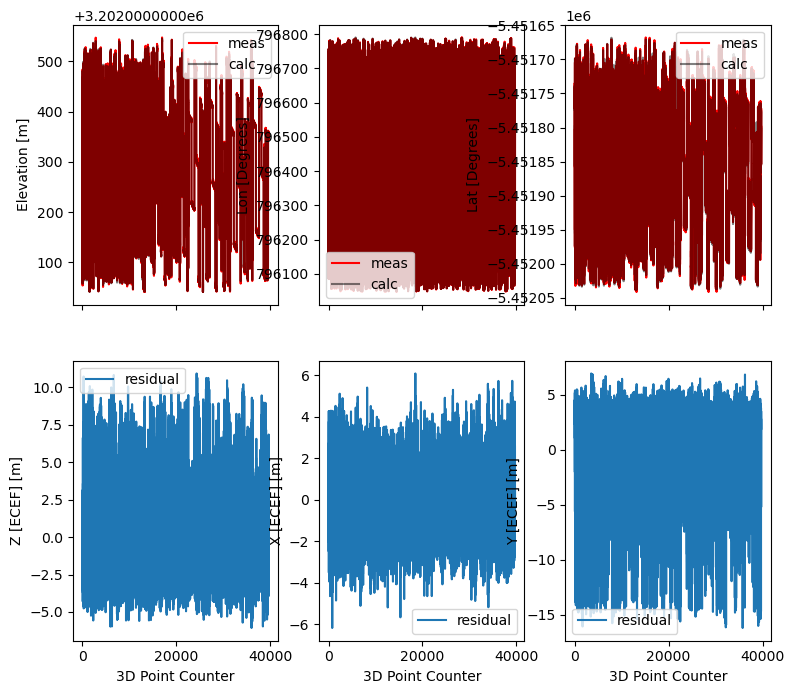

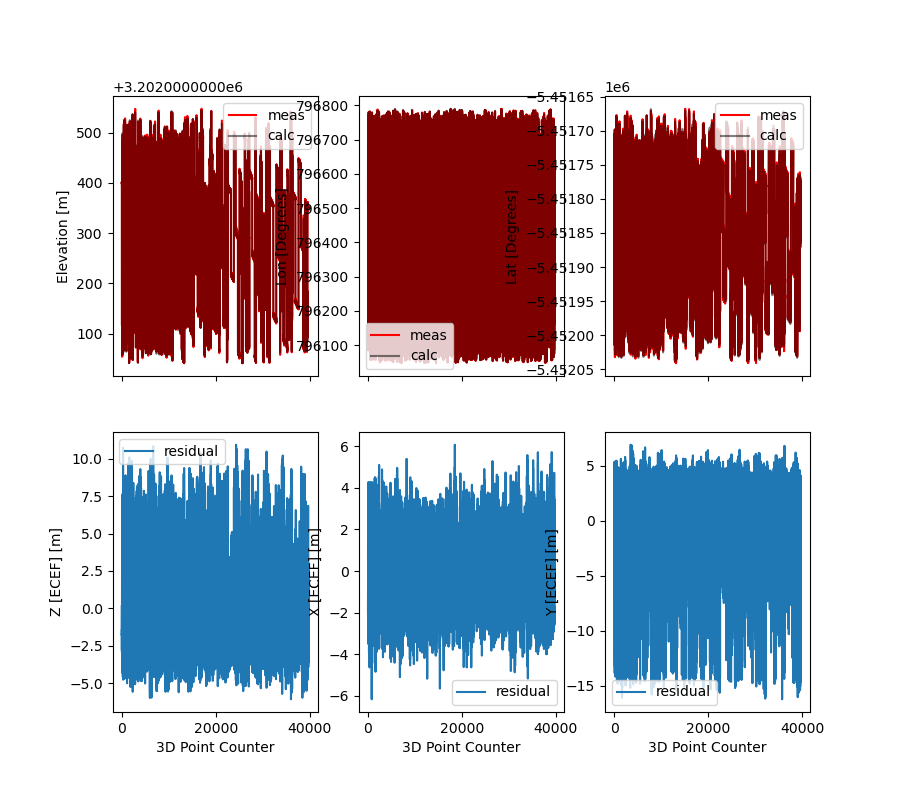

In [187]:
# Use running mean?
t1 = lsqFit.params['t1'].value
t2 = lsqFit.params['t2'].value  
t3 = lsqFit.params['t3'].value   
    
t4 = lsqFit.params['t4'].value
t5 = lsqFit.params['t5'].value  
t6 = lsqFit.params['t6'].value 
    
th1 = lsqFit.params['th1'].value
th2 = lsqFit.params['th2'].value  
th3 = lsqFit.params['th3'].value  
    
l1 = lsqFit.params['l1'].value
l2 = lsqFit.params['l2'].value  
l3 = lsqFit.params['l3'].value  
    
a1 = lsqFit.params['a1'].value
a2 = lsqFit.params['a2'].value  
a3 = lsqFit.params['a3'].value      

a4 = lsqFit.params['a4'].value
a5 = lsqFit.params['a5'].value  
a6 = lsqFit.params['a6'].value  
    
t=np.zeros(3)
t[0] = t1
t[1] = t2
t[2] = t3

    
R1=np.zeros((3,3))
R1[0,0] =1
R1[0,1] =0
R1[0,2] =0
R1[1,0] =0
R1[1,1] =np.cos(th1)
R1[1,2] =-np.sin(th1)
R1[2,0] =0
R1[2,1] =np.sin(th1)
R1[2,2] =np.cos(th1)
 
R2=np.zeros((3,3))
R2[0,0] = np.cos(th2) 
R2[0,1] = 0
R2[0,2] = np.sin(th2)
R2[1,0] =0
R2[1,1] =1
R2[1,2] =0
R2[2,0] =-np.sin(th2)
R2[2,1] =0
R2[2,2] =np.cos(th2)
    
    
R3=np.zeros((3,3))
R3[0,0] = np.cos(th3) 
R3[0,1] = -np.sin(th3)
R3[0,2] =0
R3[1,0] =np.sin(th3)
R3[1,1] =np.cos(th3)
R3[1,2] =0
R3[2,0] =0
R3[2,1] =0
R3[2,2] =1

R=np.matmul(R3,R2) 
R = np.matmul(R,R1)
    
L=np.zeros((3,3))
L[0,0] = l1
L[1,1] = l2
L[2,2] = l3

    

S = np.zeros((3,3))
S[0,0] = t4
S[1,1] = t5
S[2,2] = t6
S[1,0] = a1
S[2,0] = a2
S[2,1] = a3
S[0,1] = a4
S[0,2] = a5
S[1,2] = a6
    
#S=np.identity(3)
U = np.matmul(R,L)
U = np.matmul(U,S)
      
    
idx=np.isfinite(ecef_z2)
DEM=ecef_z2[idx]
lon=ecef_x2[idx]
lat=ecef_y2[idx]
x=dense_x3d[idx]
y=dense_y3d[idx]
z=dense_z3d[idx]
    
c1 = 1#params['c1'].value
m1 = 1#params['m1'].value
    
    
    
window_len_meas = int(m1)
window_len_calc = int(c1)
window='flat'
    
d1 = params['d1'].value
d2 = params['d2'].value
d3 = params['d3'].value
    

#newDEM=newDEM[np.isfinite(newDEM)]
smooth_DEM = smooth(DEM,window_len_meas,window)
smooth_lon = smooth(lon,window_len_meas,window)
smooth_lat = smooth(lat,window_len_meas,window)
    
smooth_x= smooth(x,window_len_calc,window)
smooth_y= smooth(y,window_len_calc,window)
smooth_z= smooth(z,window_len_calc,window)
    
n1=-41000
n2=-1000
o1=abs(n1)-1150
o2=o1-150
l = abs(abs(n1) - abs(n2))

pos=np.linspace(0,l,l)
# interpolated smooth calc z3d
interp_calc_x=interp1d(pos,smooth_x[n1:n2])
interp_calc_y=interp1d(pos,smooth_y[n1:n2])
interp_calc_z=interp1d(pos,smooth_z[n1:n2])
    
#interp the smooth DEM
interp_dem=interp1d(pos,smooth_DEM[n1:n2])
interp_lon=interp1d(pos,smooth_lon[n1:n2])
interp_lat=interp1d(pos,smooth_lat[n1:n2])
    
# the interpolated DEM on 50->450 points of the 500
interpolated_smooth_dem = interp_dem(pos[150:o1])
interpolated_smooth_lon = interp_lon(pos[150:o1])
interpolated_smooth_lat = interp_lat(pos[150:o1])
    
    
# new, shifted smooth calc z3d points
new_pos=np.linspace(150+d1,o1+d1,o2) 
new_pos2=np.linspace(150+d2,o1+d2,o2) 
new_pos3=np.linspace(150+d3,o1+d3,o2) 
interp_smooth_calcDEM = interp_calc_z(new_pos)
interp_smooth_calc_lon = interp_calc_x(new_pos2)
interp_smooth_calc_lat = interp_calc_y(new_pos3)
    
    
tx = block_reduce(interp_smooth_calc_lon,2)
n = len(interp_smooth_calcDEM)

X = np.zeros((3,n))
x = np.zeros((3,n))

"""
x[0,:] = block_reduce(interp_smooth_calc_lon,2)
x[1,:] = block_reduce(interp_smooth_calc_lat,2)
x[2,:] = block_reduce(interp_smooth_calcDEM,2)
X[0,:] = block_reduce(interpolated_smooth_lon,2)
X[1,:] = block_reduce(interpolated_smooth_lat,2)
X[2,:] = block_reduce(interpolated_smooth_dem,2)

"""
X[0,:] = interpolated_smooth_lon
X[1,:] = interpolated_smooth_lat
X[2,:] = interpolated_smooth_dem
    
x[0,:] = interp_smooth_calc_lon
x[1,:] = interp_smooth_calc_lat
x[2,:] = interp_smooth_calcDEM



#n=len(interp_smooth_calcDEM)
res=np.zeros((3,n))
full = np.zeros((3,n))
    
    
for i in range(n):
    full[:,i] =  np.matmul(U ,x[:,i]) - t

# convert these to lon/lat/z
# lon_dense3d,lat_dense3d,newDEM to ECEF
#print(full[0,0],full[1,0],full[2,0])
#full[0,:],full[1,:],full[2,:] = transform(ecefProj,outProj,full[0,:],full[1,:],full[2,:])
#res[0,:],res[1,:],res[2,:] = transform(ecefProj,outProj,res[0,:],res[1,:],res[2,:])
#X[0,:],X[1,:],X[2,:] = transform(ecefProj,outProj,X[0,:],X[1,:],X[2,:])
#print(full[0,0],full[1,0],full[2,0])

res[0,:] = X[0,:] - full[0,:]
res[1,:] = X[1,:] - full[1,:]
res[2,:] = X[2,:] - full[2,:] 

print(np.nanmean(res[0,:]),np.nanmean(res[1,:]),np.nanmean(res[2,:]))

fig, ax = plt.subplots(2,3, sharex=True,figsize= (9,8))

ax[0,2].plot(X[1,:],label='meas',color='red')
ax[0,2].plot(full[1,:],label='calc',color='black',alpha=0.5)
ax[0,2].set_ylabel('Lat [Degrees]')
ax[0,2].legend()
ax[1,2].plot(res[1,:],label='residual')
ax[1,2].set_ylabel('Lat [Degrees]')
ax[1,2].set_ylabel('Y [ECEF] [m]')
ax[1,2].set_xlabel('3D Point Counter')
ax[1,2].legend()

ax[0,1].plot(X[0,:],label='meas',color='red')
ax[0,1].plot(full[0,:],label='calc',color='black',alpha=0.5)
ax[0,1].set_ylabel('Lon [Degrees]')
ax[0,1].legend()
ax[1,1].plot(res[0,:],label='residual')
#ax[1,1].set_ylabel('Lon [Degrees]')
ax[1,1].set_ylabel('X [ECEF] [m]')
ax[1,1].set_xlabel('3D Point Counter')
ax[1,1].legend()


ax[0,0].plot(X[2,:],label='meas',color='red')
ax[0,0].plot(full[2,:],label='calc',color='black',alpha=0.5)
#ax[0,0].plot(x[2,:],label='calc',color='black',alpha=0.5)
ax[0,0].set_ylabel('Elevation [m]')
ax[0,0].legend()
ax[1,0].plot(res[2,:],label='residual')
#ax[1,0].set_ylabel('Elevation [m]')
ax[1,0].set_ylabel('Z [ECEF] [m]')
ax[1,0].set_xlabel('3D Point Counter')
ax[1,0].legend()

#fig.tight_layout()
display(fig)
#plt.show()
#plt.close()


In [168]:
print(full.shape,lon_dense3d.shape,x1.shape,y1.shape,z1.shape)

(3, 39700) (107525,) (89026,) (89026,) (89026,)


In [ ]:
ns = 1



x=X[0,::ns]
y=full[1,::ns]
z=full[2,::ns]
#x=X[0,:]
#y=X[1,:]
#z=full[2,:]


#idx=np.isfinite(newDEM)
#DEM=ecef_z2[idx]#newDEM[idx]
#x=x[idx]#lon_dense3d[idx]
#y=y[idx]



#idx=np.isfinite(x)
#x=x[idx]
#y=y[idx]
#z=z[idx]
#print(x.shape,y.shape,z.shape)

#idx=np.isfinite(y)
#x=x[idx]
#y=y[idx]
#z=z[idx]

#print(x.shape,y.shape,z.shape)

#idx=np.isfinite(z)
#x=x[idx]
#y=y[idx]
#z=z[idx]

#fig=plt.figure()
#plt.scatter(kp_sparse[0,:],kp_sparse[1,:])
#plt.scatter(x,y,alpha=0.1)
#display(fig)


vmax = np.nanmax(z)
vmin = np.nanmin(z)

color = 255*z.flatten() / vmax

idx = np.isfinite(z.flatten())

fname = 'image1.'
fname=fname+'kml'
fname = os.path.join(os.getcwd(),fname)
print(fname)

#make_kml(x.flatten(),y.flatten(),z.flatten(),color,fname)


### Let us try a full RT transformation of the point cloud [dense_x3d,dense_y3d,dense_z3d],
### to [lon,lat,DTM]

### Obtain GEDI beam locations for this area

### Minimization routine for GEDI Vs. 3D points